In [6]:
# My usual setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas 
from datetime import datetime
import seaborn as sns
import glob
from os.path import basename
sns.set_context('poster') 
import numpy as np
import csv

# Sonify 2005 hurricane season

- Original tutorial https://github.com/cirlabs/miditime
- I handle most manipulations in dataframe for ease of IO

## First, format hurricane files

NOAA format has the hurricane name in a single row, chunking rows of information about the hurricane.
We flatten it into a single CSV.

In [38]:
with open('../data/2005-hurricanes-combined') as in_file:
    with open('../data/2005-hurricanes-formatted.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(["storm_name", "date", "hour","mph"])
        
        for l in in_file:
            row = l.split(",")
            
            if len(row) == 4 :
                stormid, stormname, stormnum, blank = row
                #print(stormname)
            
            else:
                date, hour, mph = row[0], row[1], row[6]
                writer.write([stormname, date, hour, mph])
                 

Now we get the max mph for each hurricane in 2005. 

In [39]:
df = pandas.read_csv('../data/2005-hurricanes-formatted.csv')

In [60]:
df.iloc[915]

storm_name      ADRIAN
date          20050519
hour              1700
mph                 70
Name: 915, dtype: object

In [67]:
# Take note of this 🐼 witchcraft!!!
max_mph = df.iloc[df.groupby('storm_name').mph.idxmax()]
len(max_mph) == len(set(df.storm_name)) # test to make sure you got the correct max

True

Format date

In [71]:
# fill zeroes
max_mph['timestr'] = max_mph.hour.apply(lambda x: str(x).zfill(4))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
max_mph['datetime'] = pandas.to_datetime(max_mph.apply(lambda x: str(x['date']) + x['timestr'], axis=1), format="%Y%m%d%H%M")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
max_mph.head()

,storm_name,date,hour,mph,timestr,datetime
915,ADRIAN,20050519,1700,70,1700,2005-05-19 17:00:00
754,ALPHA,20051023,0,45,0000,2005-10-23 00:00:00
10,ARLENE,20050611,0,60,0000,2005-06-11 00:00:00
928,BEATRIZ,20050623,0,45,0000,2005-06-23 00:00:00
777,BETA,20051030,600,100,0600,2005-10-30 06:00:00


In [75]:
print(max_mph.datetime.max())
print(max_mph.datetime.min())

2005-12-31 06:00:00
2005-05-19 17:00:00


In [76]:
max_mph.to_csv('../data/2005-hurricanes-maxspeed.csv')

## Chart data LEFT OFF HERE!!!!!!!

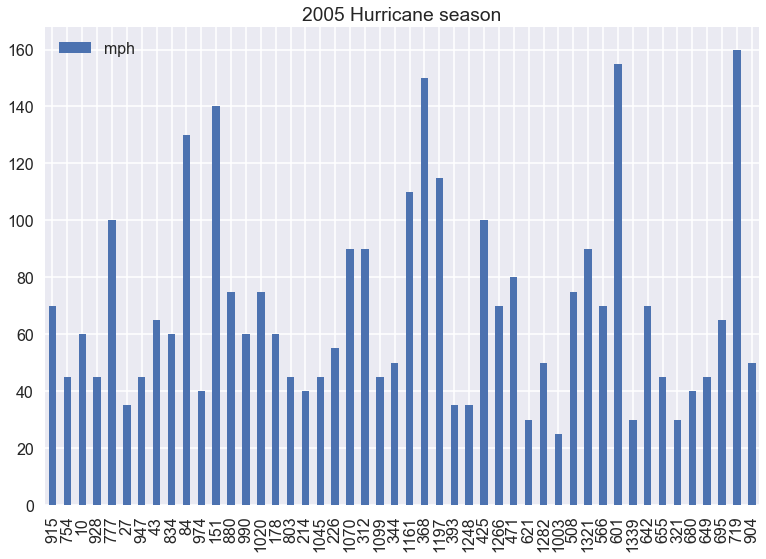

In [83]:
max_mph[['datetime','mph']].plot(kind='bar')
plt.title('2005 Hurricane season')

## MIDITime initialization

Instantiate the class with a tempo (120bpm is the default), an output file destination, the number of seconds you want to represent a year in the final song (default is 5 sec/year), the base octave (C5 is middle C, so the default is 5, and how many octaves you want your output to range over (default is 1).

In [9]:
from miditime.miditime import MIDITime
BPM = 120
FILENAME = '../audio/katrina-sonify.mid'
SEC_PER_YEAR = 365
BASE_OCTAVE = 5
OCTAVES = 1

mymidi = MIDITime(BPM,FILENAME, SEC_PER_YEAR, BASE_OCTAVE, OCTAVES)

Convert your date/time data into an integer, like days since the epoch (Jan. 1, 1970). You can use the days_since_epoch() helper method, or not:

In [10]:
df['epoched'] = df.datetime.apply(lambda x: mymidi.days_since_epoch(x))

## We can't use beat helper, our data spans only 8 days

Convert your integer date/time to something reasonable for a song. For example, at 120 beats per minute, you'll need to scale the data down a lot to avoid a very long song if your data spans years. This uses the seconds_per_year attribute you set at the top, so if your date is converted to something other than days you may need to do your own conversion. But if your dataset spans years and your dates are in days (with fractions is fine), use the beat() helper method.

In [11]:
df['beat'] = df['epoched'].apply(lambda x: mymidi.beat(x))

In [12]:
START_TIME = df.beat.min() # beat doesn't start at 0 since we scaled our epoch seconds, so we just start at the first one.
print(START_TIME)

26019.68


In [13]:
df.head(34)

,date,time,mph,timestr,datetime,epoched,beat
0,20050823,1800,30,1800,2005-08-23 18:00:00,13018.750000,26019.68
1,20050824,0,30,0000,2005-08-24 00:00:00,13019.000000,26020.18
2,20050824,600,30,0600,2005-08-24 06:00:00,13019.250000,26020.68
3,20050824,1200,35,1200,2005-08-24 12:00:00,13019.500000,26021.18
4,20050824,1800,40,1800,2005-08-24 18:00:00,13019.750000,26021.68
5,20050825,0,45,0000,2005-08-25 00:00:00,13020.000000,26022.18
6,20050825,600,50,0600,2005-08-25 06:00:00,13020.250000,26022.68
7,20050825,1200,55,1200,2005-08-25 12:00:00,13020.500000,26023.18
8,20050825,1800,60,1800,2005-08-25 18:00:00,13020.750000,26023.68
9,20050825,2230,70,2230,2005-08-25 22:30:00,13020.937500,26024.05


In [14]:
MAX = df.mph.max()
MIN = df.mph.min()
print(MIN,MAX)

25 150


## Create scale from mph 

Use linear scale.

In [15]:
def mag_to_pitch_tuned(mph):
    # Where does this data point sit in the domain of your data? (I.E. the min mph is 3, the max in 5.6). In this case the optional 'True' means the scale is reversed, so the highest value will return the lowest percentage.
    #scale_pct = mymidi.linear_scale_pct(MIN, MAX, mph)

    # Another option: Linear scale, reverse order
    #scale_pct = mymidi.linear_scale_pct(MIN, MAX, mph, True)

    # Another option: Logarithmic scale, reverse order
    scale_pct = mymidi.log_scale_pct(MIN, MAX, mph, True)

    # Pick a range of notes. This allows you to play in a key.
    c_major = ['C', 'D', 'E', 'F', 'G', 'A', 'B']

    #Find the note that matches your data point
    note = mymidi.scale_to_note(scale_pct, c_major)

    #Translate that note to a MIDI pitch
    midi_pitch = mymidi.note_to_midi_pitch(note)

    return midi_pitch


In [16]:
df['pitch'] = df.mph.apply(lambda x: mag_to_pitch_tuned(x))

 ### Let's also make larger mph louder.

In [17]:
MIN_V = 25
MAX_V = 150
df['velocity'] = df.mph.apply(lambda x: int(np.interp(x, [MIN,MAX], [25, 150])))

In [18]:
df.velocity


0      30
1      30
2      30
3      35
4      40
5      45
6      50
7      55
8      60
9      70
10     70
11     65
12     75
13     85
14     90
15     95
16    100
17    100
18    100
19    125
20    145
21    150
22    140
23    125
24    110
25    110
26    105
27     80
28     50
29     40
30     30
31     30
32     30
33     25
Name: velocity, dtype: int64

## Build note list
- I know you're not supposed to iterate through a dataframe — but it's pretty small and manegable.
- [BEAT, PITCH, VELOCITY (VOLUME), DURATION_OF_NOTE]

In [19]:
scaled_data = df.to_dict('records')

In [20]:
note_list = []  
#V = 100 # constant for now
D = 1 # duration constant for now

for d in scaled_data:
    beat = d['beat'] - START_TIME
    pitch = d['pitch']
    velocity = d['velocity']
    duration = D
    note_list.append([beat, pitch, velocity, duration])


In [21]:
note_list

[[0.0, 71, 30, 1],
 [0.5, 71, 30, 1],
 [1.0, 71, 30, 1],
 [1.5, 71, 35, 1],
 [2.0, 71, 40, 1],
 [2.5, 71, 45, 1],
 [3.0, 71, 50, 1],
 [3.5, 71, 55, 1],
 [4.0, 71, 60, 1],
 [4.3699999999989814, 71, 70, 1],
 [4.5, 71, 70, 1],
 [4.9899999999979627, 71, 65, 1],
 [5.4899999999979627, 71, 75, 1],
 [5.9899999999979627, 71, 85, 1],
 [6.4899999999979627, 71, 90, 1],
 [6.9899999999979627, 71, 95, 1],
 [7.4899999999979627, 71, 100, 1],
 [7.9899999999979627, 71, 100, 1],
 [8.4899999999979627, 71, 100, 1],
 [8.9899999999979627, 71, 125, 1],
 [9.4899999999979627, 71, 145, 1],
 [9.9899999999979627, 71, 150, 1],
 [10.489999999997963, 71, 140, 1],
 [10.989999999997963, 71, 125, 1],
 [11.419999999998254, 71, 110, 1],
 [11.489999999997963, 71, 110, 1],
 [11.720000000001164, 71, 105, 1],
 [11.989999999997963, 71, 80, 1],
 [12.489999999997963, 71, 50, 1],
 [12.989999999997963, 71, 40, 1],
 [13.489999999997963, 71, 30, 1],
 [13.989999999997963, 71, 30, 1],
 [14.489999999997963, 71, 30, 1],
 [14.989999999997

## Make MIDI file

In [22]:
# Add a track with those notes
mymidi.add_track(note_list)

# Output the .mid file
mymidi.save_midi()

71 0.0 1 30
71 0.5 1 30
71 1.0 1 30
71 1.5 1 35
71 2.0 1 40
71 2.5 1 45
71 3.0 1 50
71 3.5 1 55
71 4.0 1 60
71 4.37 1 70
71 4.5 1 70
71 4.99 1 65
71 5.49 1 75
71 5.99 1 85
71 6.49 1 90
71 6.99 1 95
71 7.49 1 100
71 7.99 1 100
71 8.49 1 100
71 8.99 1 125
71 9.49 1 145
71 9.99 1 150
71 10.49 1 140
71 10.99 1 125
71 11.42 1 110
71 11.49 1 110
71 11.72 1 105
71 11.99 1 80
71 12.49 1 50
71 12.99 1 40
71 13.49 1 30
71 13.99 1 30
71 14.49 1 30
71 14.99 1 25
